# Spatial resolution of PET is a confound in voxelwise analysis

Below is an example in 1-D illustrating the problem we encounter in voxelwise analysis of PET data in standardized space.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

%matplotlib inline

In [2]:
def rect(x):
    return (np.abs(x)<=0.5).astype(float)

First, we generate sample 1-D "images" for three subjects. In the "true intensity" images, a value of 0 represents ventricles and 1 represents surrounding white matter.

In [3]:
xrange = np.linspace(-5,5,5000)

template_anatomy = 1 - rect(xrange)

subj1_anatomy = 1 - rect(2*xrange)
subj2_anatomy = 1 - rect(xrange/2)
subj3_anatomy = 1 - rect(xrange)

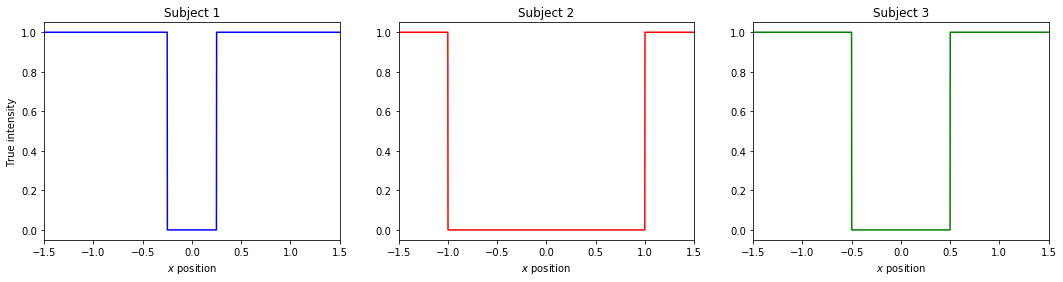

In [4]:
figsize(18,4)
plt.subplot(1,3,1)
plt.plot(xrange, subj1_anatomy, 'b');
plt.xlim([-1.5,1.5]);
plt.title('Subject 1');
plt.xlabel('$x$ position');
plt.ylabel('True intensity');
plt.subplot(1,3,2)
plt.plot(xrange, subj2_anatomy, 'r');
plt.xlim([-1.5,1.5]);
plt.title('Subject 2');
plt.xlabel('$x$ position');
plt.subplot(1,3,3)
plt.plot(xrange, subj3_anatomy, 'g');
plt.xlim([-1.5,1.5]);
plt.title('Subject 3');
plt.xlabel('$x$ position');

Subject 1 has the smallest ventricle, and subject 2 has the largest.

Now we take a look at the point spread function (PSF) of the PET scanner:

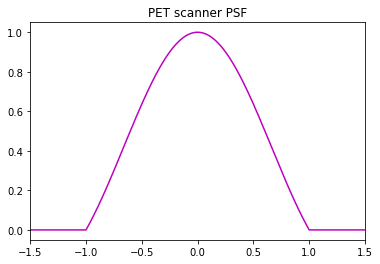

In [5]:
psf = np.sinc(xrange)
psf[np.abs(xrange)>1] = 0
figsize(6,4)
plt.plot(xrange,psf, 'm');
plt.xlim([-1.5,1.5]);
plt.title('PET scanner PSF');

When we image using this scanner, the true anatomy will be blurred:

In [6]:
subj1_pet = np.convolve(subj1_anatomy, psf, 'same')
subj2_pet = np.convolve(subj2_anatomy, psf, 'same')
subj3_pet = np.convolve(subj3_anatomy, psf, 'same')

subj1_pet = subj1_pet / subj1_pet.max()
subj2_pet = subj2_pet / subj2_pet.max()
subj3_pet = subj3_pet / subj3_pet.max()

Below, the dashed lines indicate true anatomy, and the solid lines indicate the blurred anatomy as observed in the PET scan.

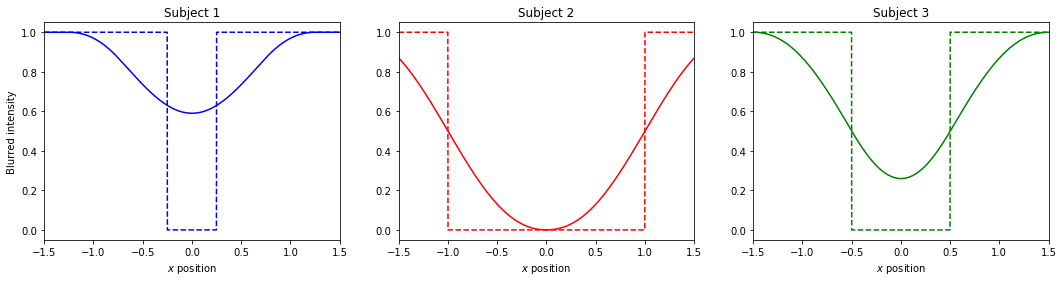

In [7]:
figsize(18,4)
plt.subplot(1,3,1)
plt.plot(xrange, subj1_pet, 'b');
plt.plot(xrange, subj1_anatomy, 'b', linestyle='dashed')
plt.xlim([-1.5,1.5]);
plt.title('Subject 1');
plt.xlabel('$x$ position');
plt.ylabel('Blurred intensity');
plt.subplot(1,3,2)
plt.plot(xrange, subj2_pet, 'r');
plt.plot(xrange, subj2_anatomy, 'r', linestyle='dashed')
plt.xlim([-1.5,1.5]);
plt.title('Subject 2');
plt.xlabel('$x$ position');
plt.subplot(1,3,3)
plt.plot(xrange, subj3_pet, 'g');
plt.plot(xrange, subj3_anatomy, 'g', linestyle='dashed')
plt.xlim([-1.5,1.5]);
plt.title('Subject 3');
plt.xlabel('$x$ position');

Now, we want to align the anatomies of each of these individuals onto our template.

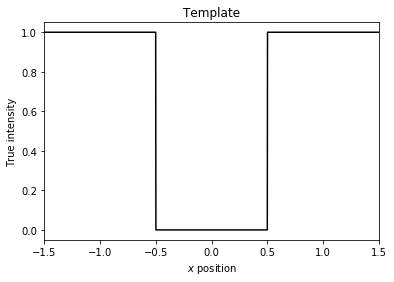

In [8]:
figsize(6,4)
plt.plot(xrange, template_anatomy, 'k')
plt.xlim([-1.5,1.5]);
plt.title('Template');
plt.xlabel('$x$ position');
plt.ylabel('True intensity');

We will assume that we know the true mapping between each subject and the template. (In real-life applications, we can obtain quite accurate mappings using structural MRIs.)

First, we consider the scenario where we only allow global scaling in the transformation between template space and subject space.

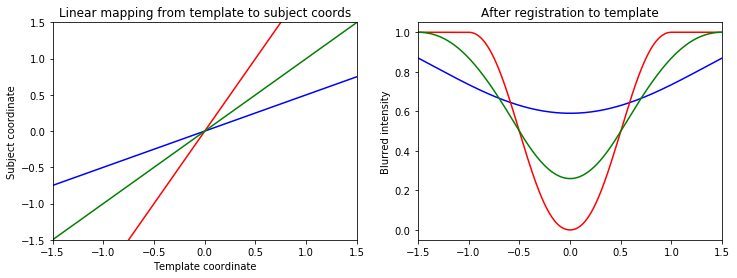

In [16]:
from scipy.interpolate import NearestNDInterpolator
# transformation taking a point in template space and mapping into subject1 space
def T1(x):
    return x/2

def T2(x):
    return 2*x

def T3(x):
    return x

figsize(12,4)
plt.subplot(1,2,1)
plt.plot(xrange,T1(xrange), 'b')
plt.plot(xrange,T2(xrange), 'r')
plt.plot(xrange,T3(xrange), 'g')
plt.xlim([-1.5,1.5]);
plt.ylim([-1.5,1.5]);
plt.title('Linear mapping from template to subject coords');
plt.xlabel('Template coordinate');
plt.ylabel('Subject coordinate');
plt.subplot(1,2,2)
plt.plot(xrange, np.interp(T1(xrange), xrange, subj1_pet), 'b');
plt.plot(xrange, np.interp(T2(xrange), xrange, subj2_pet), 'r');
plt.plot(xrange, np.interp(T3(xrange), xrange, subj3_pet), 'g');
plt.xlim([-1.5,1.5]);
plt.title('After registration to template');
plt.ylabel('Blurred intensity');

As seen in the plot above to the right, after we bring the PET images into template space, the subject with smallest ventricles (subject 1, blue) has an intensity much higher than 0 inside the ventricles. Larger ventricles attain lower signal. This is a problem because in voxelwise analyses, we might find (falsely, that is) that older individuals (larger ventricles) have lower activity in the ventricles.

Now we consider a nonlinear mapping between template space and subject space:

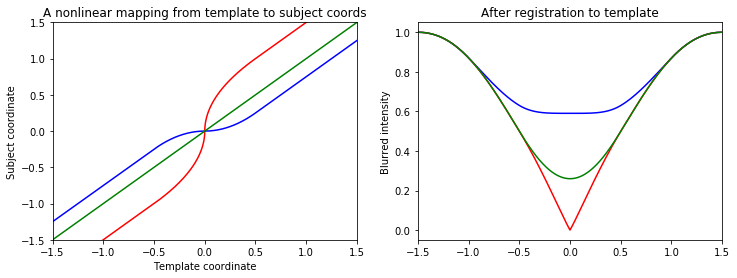

In [287]:
# transformation taking a point in template space and mapping into subject1 space
def T1(x):
    res = np.sign(x)*x**2
    res[np.abs(x)>0.5] = (np.sign(x)*(np.abs(x) - 0.5**2))[np.abs(x)>0.5]
    return res
    #return np.sign(x)*x**2 # and just x - 0.5**2 beyond 0.5

def T2(x):
    res = np.sign(x)*np.sqrt(np.abs(x*2))
    res[np.abs(x)>0.5] = (np.sign(x)*(np.abs(x) + 0.5))[np.abs(x)>0.5]
    return res
    #return np.sign(x)*np.sqrt(np.abs(x*2)) # and just x + 0.5 beyond 0.5

def T3(x):
    return x

def detJ_T1(x):
    res = 2*np.abs(x)
    res[np.abs(x)>0.5] = 1
    return res

def detJ_T2(x):
    res = 1 / np.sqrt(2*np.abs(x))
    res[np.abs(x)>0.5] = 1
    return res

figsize(12,4)
plt.subplot(1,2,1)
plt.plot(xrange,T1(xrange), 'b')
plt.plot(xrange,T2(xrange), 'r')
plt.plot(xrange,T3(xrange), 'g')
plt.xlim([-1.5,1.5]);
plt.ylim([-1.5,1.5]);
plt.title('A nonlinear mapping from template to subject coords');
plt.xlabel('Template coordinate');
plt.ylabel('Subject coordinate');
plt.subplot(1,2,2)
plt.plot(xrange, np.interp(T1(xrange), xrange, subj1_pet), 'b');
plt.plot(xrange, np.interp(T2(xrange), xrange, subj2_pet), 'r');
plt.plot(xrange, np.interp(T3(xrange), xrange, subj3_pet), 'g');
plt.xlim([-1.5,1.5])
plt.title('After registration to template');
plt.ylabel('Blurred intensity');

The nonlinear mapping may (as in this example) or may not improve the discrepancy we see in the PET intensities. The main problem inside the ventricles remains.

We can try to correct for the ventricle intensity discrepancy by modulating the PET intensities by the determinant of the jacobian (which describes how much the coordinate system is stretching or shrinking going from the template space to subject space).

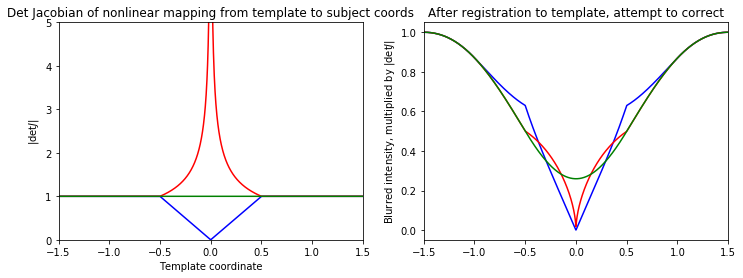

In [286]:
figsize(12,4)
plt.subplot(1,2,1)
plt.plot(xrange,detJ_T1(xrange), 'b')
plt.plot(xrange,detJ_T2(xrange), 'r')
plt.plot(xrange,np.ones(len(xrange)), 'g')
plt.xlim([-1.5,1.5]);
plt.ylim([0,5]);
plt.title('Det Jacobian of nonlinear mapping from template to subject coords');
plt.xlabel('Template coordinate');
plt.ylabel('$|\det J|$');
plt.subplot(1,2,2)
plt.plot(xrange, np.interp(T1(xrange), xrange, subj1_pet) * detJ_T1(xrange), 'b');
plt.plot(xrange, np.interp(T2(xrange), xrange, subj2_pet) * detJ_T2(xrange), 'r');
plt.plot(xrange, np.interp(T3(xrange), xrange, subj3_pet) * 1, 'g');
plt.xlim([-1.5,1.5])
plt.title('After registration to template, attempt to correct');
plt.ylabel('Blurred intensity, multiplied by $|\det J|$');

Intensities inside the ventricles are now matching better.